# HW 3
The goal of this homework is to learn how to leverage pretrained convnets and to use some visualization techniques. You will work with the data set cats vs dogs and use the pretrained convnet VGG19.

Experiment with different classifiers, trying to maximize the validation accuracy. You only need to show one classifier.

**Problem 1**
Do feature extraction with data augmentation.

**Problem 2**
Do fine-tuning with data augmentation.

**Problem 3**
Visualize heatmaps of class activation for the the model obtained in Problem 2.

**Problem 4**
Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.

##Problem 1

---
**Do feature extraction with data augmentation.**




####Download The Data

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 20:40:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  81.3MB/s    in 0.8s    

2019-04-18 20:40:49 (81.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

####Loading VGG19 as the convolutional base

In [4]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____

####Freezing the Convolutional Base

In [0]:
conv_base.trainable = False

####Concatenating the convolutional base and densely connected layers

In [6]:
from keras import layers
from keras import models
from keras import optimizers
#
m = conv_base.output
m=layers.Flatten()(m)
m=layers.Dense(256, activation='relu')(m)
#
m = layers.Dense(1, activation='sigmoid')(m)
model = models.Model(inputs=[conv_base.input], outputs=[m])
#

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

####Training the dense layers

In [0]:
for idx,layer in enumerate(model.layers):
  layer.trainable = idx >= 22 #Until 22nd Layer, trainable is set to false

**Training the model end to end with frozen convolutional base**

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 23s 231ms/step - loss: 0.6032 - acc: 0.6690 - val_loss: 0.4863 - val_acc: 0.7970
Epoch 2/30
100/100 [==============================] - 19s 186ms/step - loss: 0.5231 - acc: 0.7440 - val_loss: 0.4269 - val_acc: 0.8140
Epoch 3/30
100/100 [==============================] - 18s 177ms/step - loss: 0.4783 - acc: 0.7770 - val_loss: 0.3738 - val_acc: 0.8320
Epoch 4/30
100/100 [==============================] - 18s 178ms/step - loss: 0.4521 - acc: 0.8030 - val_loss: 0.3456 - val_acc: 0.8530
Epoch 5/30
100/100 [==============================] - 18s 177ms/step - loss: 0.4202 - acc: 0.8150 - val_loss: 0.3565 - val_acc: 0.8430
Epoch 6/30
100/100 [==============================] - 19s 192ms/step - loss: 0.4118 - acc: 0.8070 - val_loss: 0.3194 - val_acc: 0.8520
Epoch 7/30
100/100 [==============================] - 18s 

####Displaying Accuracy and Loss in Training and Validation phase

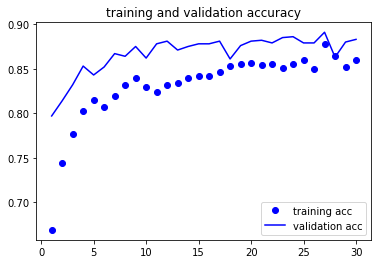

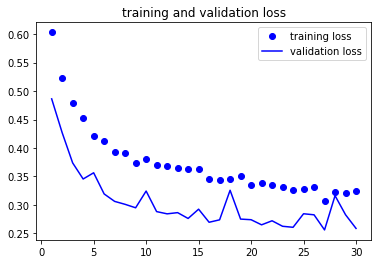

Validation loss: 0.2546410420536995
Validation accuracy: 0.8819999980926514


In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

#
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
#
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)
#

####Saving the model in Colab

In [10]:
model_fname1 = 'catsdogsclassifier_p1.h5' 
model.save(model_fname1)
print("Model saved in Colab")

Model saved in Colab


In [11]:
from google.colab import files

with open(model_fname1, 'r') as f:
  files.download(model_fname1)
print("Model_p1 downloaded on Local disk")
print("Problem 1 Ends")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 58746, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

Model_p1 downloaded on Local disk
Problem 1 Ends


## **Problem 2**

---

**Do fine-tuning with data augmentation.**

####Loading model from Problem 1

In [12]:
from keras.models import load_model  
    
modelp2 = load_model(model_fname1)
modelp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

####Setting the last Conv layer and the FC layers as trainable

In [0]:
for idx,layer in enumerate(modelp2.layers):
  layer.trainable = idx >= 20

In [14]:
modelp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


####Training the finetuned model

In [15]:
# compile model

modelp2.compile(
  loss='binary_crossentropy', 
  optimizer=optimizers.RMSprop(lr=2e-5), 
  metrics=['acc'])

# train

history = modelp2.fit_generator(
  train_generator,
  steps_per_epoch=100,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=30
)

Epoch 1/30
100/100 [==============================] - 18s 180ms/step - loss: 0.3187 - acc: 0.8565 - val_loss: 0.3010 - val_acc: 0.8617
Epoch 2/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3151 - acc: 0.8680 - val_loss: 0.2425 - val_acc: 0.8933
Epoch 3/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3029 - acc: 0.8730 - val_loss: 0.3650 - val_acc: 0.8450
Epoch 4/30
100/100 [==============================] - 18s 175ms/step - loss: 0.3174 - acc: 0.8620 - val_loss: 0.2392 - val_acc: 0.8967
Epoch 5/30
100/100 [==============================] - 16s 165ms/step - loss: 0.2938 - acc: 0.8700 - val_loss: 0.2666 - val_acc: 0.8733
Epoch 6/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3029 - acc: 0.8730 - val_loss: 0.2534 - val_acc: 0.9017
Epoch 7/30
100/100 [==============================] - 16s 163ms/step - loss: 0.2763 - acc: 0.8785 - val_loss: 0.2672 - val_acc: 0.8900
Epoch 8/30
100/100 [==============================] - 1

####Displaying Training and Validation accuracy for finetuned model

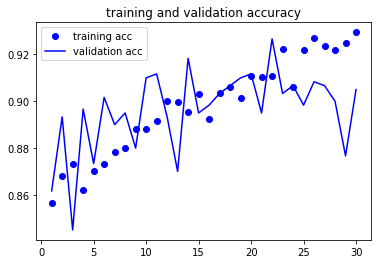

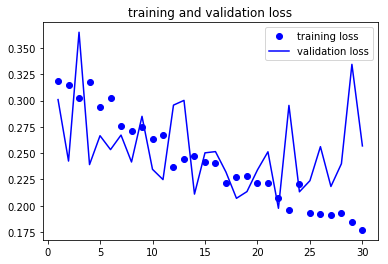

Validation loss: 0.2219977204501629
Validation accuracy: 0.9169999957084656


In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()
#
val_loss, val_acc = modelp2.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)
#

####Saving and Downloading the model

In [17]:
model_fname2 = 'catsdogsclassifier_p2.h5' 
modelp2.save(model_fname2)
print("Modelp2 saved in Colab")

Modelp2 saved in Colab


In [18]:
with open(model_fname2, 'r') as f:
  files.download(model_fname2)
print("Modelp2 downloaded in Disk")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 50650, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

Modelp2 downloaded in Disk


In [19]:
modelp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## **Problem 3 (a) [With imported model from Problem 2]**

---

**Visualize heatmaps of class activation for the the model obtained in Problem 2.**

####Loading model from Problem 2

In [20]:
modelp3 = load_model('catsdogsclassifier_p2.h5')
modelp3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
images, labels = next(validation_generator)

####Process_image function for adjusting the input for our model

In [0]:
from keras import backend as K
import numpy as np
import cv2

last_conv_layer = modelp3.get_layer('block5_conv4') #Will use this layer's output for computing gradient

def process_image(img):
    
    grads = K.gradients(modelp3.output[0], last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([modelp3.input], [pooled_grads, last_conv_layer.output[0], modelp3.output[0]])
    
    x = np.expand_dims(img, axis=0)
    pooled_grads_value, conv_layer_output_value, pred_value = iterate([x])
    
    if pred_value[0] < 1.0:
      if pred_value[0] < 0.5:
          conv_layer_output_value = 1-conv_layer_output_value 
      for i in range(512):
          conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    # normalize
    heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())

    heatmap_adj = cv2.resize(1-heatmap, (img.shape[1], img.shape[0]))
    heatmap_adj = np.uint8(255 * heatmap_adj)
    heatmap_adj = cv2.applyColorMap(heatmap_adj, cv2.COLORMAP_JET)
    
    superimposed_img = np.uint8(heatmap_adj * 0.4 + np.uint8(255 * img) * 0.6)
    
    return superimposed_img, pred_value[0], heatmap_adj

####Showing the heatmap

ValueError: ignored

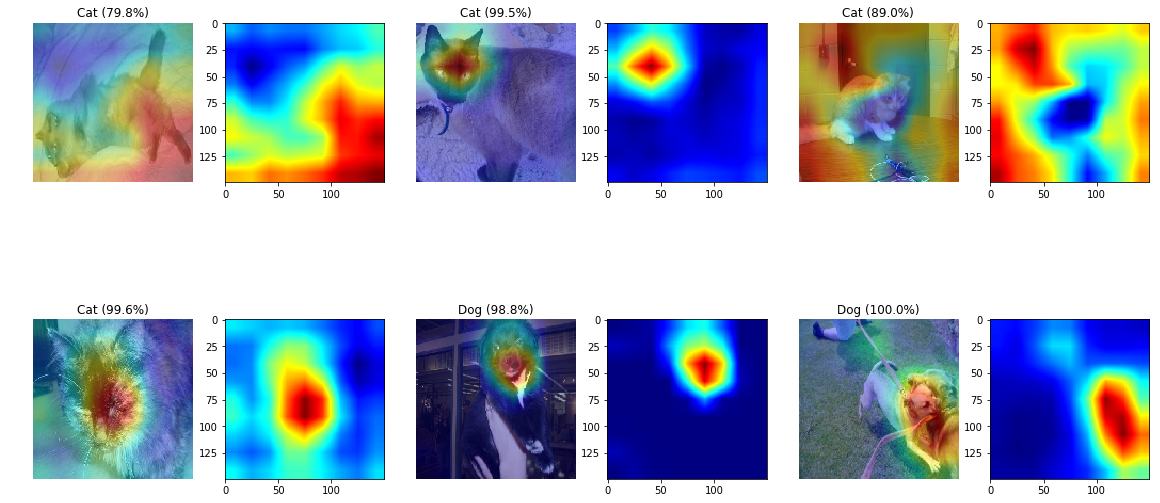

In [23]:
fig = plt.figure(figsize=(20, 10))
j=1
for i,img in enumerate(images[:10,]):
  superimposed_img, pred, heatmap = process_image(img)
  plt.subplot(2, 6, j)
  plt.imshow(superimposed_img)

  if pred < 0.5:
      class_name = "Cat"
      pred = 1-pred
  else:
    class_name = "Dog"

  plt.title("{} ({:.1f}%)".format(class_name, pred*100))
  plt.axis('off')

  plt.subplot(2, 6, j+1)
  plt.imshow(heatmap)

  j=j+2;
plt.show()

## **Problem 3 (b) [With pretrained VGG19]**

---

**Visualize heatmaps of class activation for a pre-trained VGG19.**

In [24]:
from tensorflow.keras.applications.vgg19 import VGG19
model3b = VGG19(weights='imagenet')

574717952/574710816 [==============================] - 42s 0us/step


In [26]:
!wget http://www.autofish.net/mirrors/images/animals/cats/puddin-head_frog.jpg -O cat1.jpg
!wget https://i.imgur.com/BHoBUOx.jpg -O cat2.jpg
!wget https://static1.fjcdn.com/comments/My+cat+is+a+boss+this+random+cat+came+into+_1644264be0fbb51dc712b8c884d0036e.jpeg -O cat3.jpg
!wget http://static.flickr.com/30/63687171_08a1afa6c0.jpg -O dog1.jpg
!wget http://www.dogshow.com/wp-content/uploads/2015/02/78715381.jpg -O dog2.jpg

--2019-04-18 21:05:00--  http://www.autofish.net/mirrors/images/animals/cats/puddin-head_frog.jpg
Resolving www.autofish.net (www.autofish.net)... 64.130.10.14
Connecting to www.autofish.net (www.autofish.net)|64.130.10.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69795 (68K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>]  68.16K   152KB/s    in 0.4s    

2019-04-18 21:05:02 (152 KB/s) - ‘cat1.jpg’ saved [69795/69795]

--2019-04-18 21:05:04--  https://i.imgur.com/BHoBUOx.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.24.193
Connecting to i.imgur.com (i.imgur.com)|151.101.24.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53625 (52K) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg            100%[===================>]  52.37K   163KB/s    in 0.3s    

2019-04-18 21:05:05 (163 KB/s) - ‘cat2.jpg’ saved [53625/53625]

--2019-04-18 21:05:08--  https://static1.fjcdn.com/comments/My+cat+is+a+boss

In [0]:
img_path1 = 'cat1.jpg'
img_path2 = 'cat2.jpg'
img_path3 = 'cat3.jpg'
img_path4 = 'dog1.jpg'
img_path5 = 'dog2.jpg'

In [0]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.applications.vgg19 import VGG19
# note that we keep the densely connected classifier;
# in the two previous vizualization methods, we discarded it
model = VGG19(weights='imagenet')
img_path1='cat1.jpg'

In [0]:
last_conv_layer = model.get_layer('block5_conv4')

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K

In [0]:

def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)

def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(224, 224))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #
  preds = model.predict(x)
  print('Predicted:', decode_predictions(preds, top=3)[0])
  #
  #class_index = np.argmax(preds[0])
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  
  class_output = model.output[:, class_index]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  #
  show_superimposed_image(img_path, heatmap)

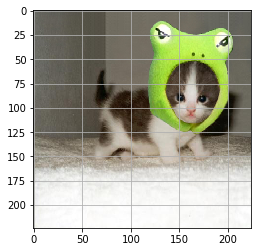

Predicted: [('n02110185', 'Siberian_husky', 0.1126513), ('n02808304', 'bath_towel', 0.07798686), ('n02342885', 'hamster', 0.077781305)]


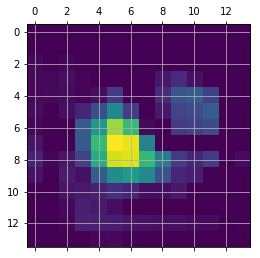

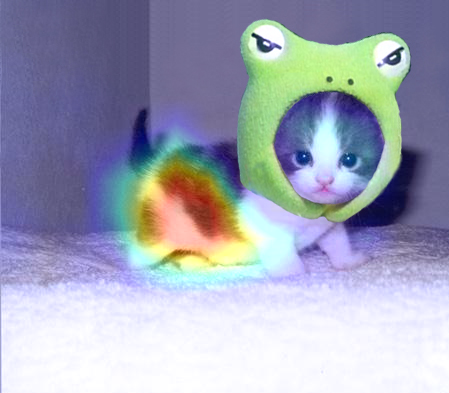

In [18]:
process_image(img_path1)

## Problem **4**

---

**Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.**

####Loading model from problem 2

In [0]:
model4 = load_model('catsdogsclassifier_p2.h5')
model4.summary()

In [0]:
layer = model4.get_layer('dense_1') #Choosing dense_1 layer for observing high level activation
layer_output = layer.output

In [0]:
activation_model = models.Model(inputs=model4.input, outputs=[layer_output])

####Visualization of 1000 validation data

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=1000,
    class_mode='binary')
images, labels = next(validation_generator)

In [0]:
activations = activation_model.predict(images)
activations.shape

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

####data_scatter function for t-SNE plot

In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

#### t-SNE processing

In [0]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

catsvsdogs_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

####Visualizing t-SNE plot for Cats vs Dogs dataset

In [0]:
class_names = ["Cat", "Dog"]
print(class_names)

data_scatter(catsvsdogs_tsne, labels)